# Label Propagation

In [1]:
import geopandas as gpd
#from shapely.geometry import Point, Polygon
import numpy as np
from sklearn.semi_supervised import LabelPropagation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import rasterio as rs
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from rasterio.plot import show
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Input Datasets

In [2]:
ttc = rs.open('../data/testing/CostaRica.tif')
sdpt = gpd.read_file('../data/testing/cri_sdpt_v2.shp')
lulc = rs.open('../data/testing/lulc_cr.tif')

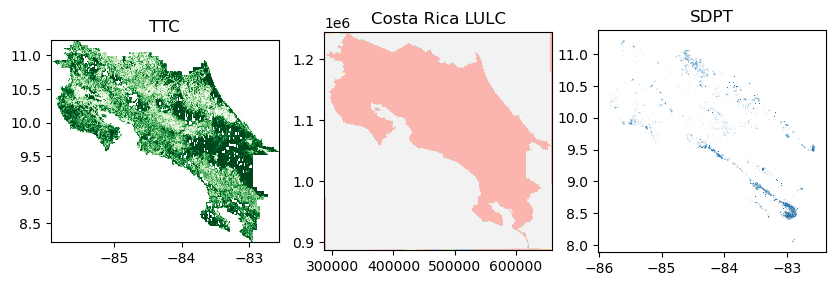

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 8))
show((ttc), cmap='Greens', ax=ax1)
show((lulc), cmap='Pastel1', ax=ax2)
sdpt.plot(ax=ax3)

ax1.set_title("TTC")
ax2.set_title("Costa Rica LULC")
ax3.set_title("SDPT");

## Data Preparation

In [2]:
#cr = gpd.read_file('../data/testing/gadm41_CRI_0.shp')
hc_poly = gpd.read_file('datasets/HighConf_poly1.shp')
labeled = gpd.read_file('datasets/HighConf_Point.shp')
unlabeled = gpd.read_file('datasets/output_unlabelledPts.shp')



### Prepare Labeled Points
In the future, this step would be removed or ideally combined with preprocessing steps for unlabeled points. 

In [3]:
# clean up column names
labeled.drop(columns=['Id', 'Area', 'gridcode', 'MERGE_SRC', 'ORIG_FID'], inplace=True)
labeled.columns = map(str.lower, labeled.columns)
labeled.rename(columns={'pclass': 'label', 'ttc_thres':'ttc'}, inplace=True)

# clean up vals and dtypes to match what will be extracted
labeled.sdpt = labeled.sdpt.map({'NA': 0.0, 'ForestPlantation': 2.0, 'oilpalm': 1.0, 'orchard': 3.0}).astype('str')
labeled.lulc = labeled.lulc.map({'urban': 10.0, 
                                 'MatureForest': 8.0,
                                 'mangrove':14.0,
                                 'FPlantation':7.0,
                                 'palm':20.0,
                                 'bare':9.0,
                                 'pineapple':22.0,
                                 'coffeeAg':23.0}).astype('str')
labeled.label = labeled.label.map({'notplantation': 0, 'monoculture': 1, 'agroforestry': 2}).astype('str')
labeled.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lulc      2194 non-null   object  
 1   label     2194 non-null   object  
 2   sdpt      2194 non-null   object  
 3   ttc       2194 non-null   int64   
 4   point_x   2194 non-null   float64 
 5   point_y   2194 non-null   float64 
 6   geometry  2194 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 120.1+ KB


In [4]:
# quick visual to get a sense of the location of labeled and unlabeled points
ax = cr.plot(figsize=(11,9))
labeled.plot(ax=ax, color='red', markersize=0.1)
unlabeled.plot(ax=ax, color='black', markersize=0.1);

NameError: name 'cr' is not defined

In [7]:
## reproject the lulc dataset to espg 4326 to match other input data
## taken verbatim from rasterio documentation w/ added compression params

from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rs.open('../data/testing/lulc_cr.tif') as src:
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'compress': 'lzw',
        'dtype': 'uint8'})

    with rs.open('../data/testing/lulc_cr_reprj.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rs.band(src, i),
                destination=rs.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

### Prepare Unlabeled Points

In [5]:
def extract_raster_values(raster, points):
    
    values = []
    for point in points.geometry:
        x, y = point.x, point.y
        row, col = raster.index(x, y)

        # Check if the point is within the raster extent
        if 0 <= row < raster.height and 0 <= col < raster.width:
            value = raster.read(1, window=((row, row + 1), (col, col + 1)))
            values.append(value[0][0])
        else:
            values.append(np.NaN)
            
    return values


In [20]:
def get_unlabeled_data(num_pts):
    
    '''
    Calculates num_pts within a designated area and extracts associated 
    attributes from 3 rasters. Returns dataframe where each row
    represents an unlabeled observation.
    
    '''
    
    # gets num_pts of unlabeled data
    print(f'Extracting {num_pts} unlabeled points...')
    
    # for now import Kanchana's generated points
    unlabeled = gpd.read_file('datasets/output_unlabelledPts.shp')
    
    # add line to avoid points on cocos island
    # add line to drop any points that are NaN or 255 from TTC or LULC

    # import ttc, sdpt and lulc data and confirm crs
    ttc = rs.open('datasets/CostaRica.tif')
    sdpt = gpd.read_file('../data/testing/cri_sdpt_v2.shp')
    lulc = rs.open('../data/testing/lulc_cr_reprj.tif')
    
    assert ttc.crs == sdpt.crs == lulc.crs == unlabeled.crs
    
    # create new df to hold extracted attributes
    df = pd.DataFrame(columns=['lulc', 'label', 'sdpt', 'ttc', 'point_x', 'point_y','geometry'])
    df['geometry'] = unlabeled.geometry
    df['point_x'] = unlabeled.geometry.x
    df['point_y'] = unlabeled.geometry.y
    df['lulc'] = extract_raster_values(lulc, unlabeled)
    df['ttc'] = extract_raster_values(ttc, unlabeled)

    # for sdpt must perform join
    # forest plantations = 2.0, orchard = 7215, oil palm = 1.0
    intersection = gpd.sjoin(unlabeled, sdpt[['originalCo', 'originalNa', 'geometry']], how='left', predicate='within')
    df['sdpt'] = intersection['originalCo']
    
    # take care of null values for modeling
    df['sdpt'] = df['sdpt'].fillna(0)
    df['label'] = df['label'].fillna(-1)
    
    # drop the point on cocos island
    df.drop(index=89, inplace=True)
    
    df[['lulc', 'label', 'sdpt']] = df[['lulc', 'label', 'sdpt']].astype(str)
    df['ttc'] = df['ttc'].astype(np.int64)
    
    return df

In [23]:
unlabeled.head(5)

,FID,geometry
0,0,POINT (-84.48344 10.80454)
1,1,POINT (-84.43451 9.79718)
2,2,POINT (-82.61249 9.58896)
3,3,POINT (-83.16109 9.07203)
4,4,POINT (-85.56758 10.75486)


In [22]:
unlabeled = get_unlabeled_data(2000)
unlabeled.head()

Extracting 2000 unlabeled points...


DriverError: ../data/testing/cri_sdpt_v2.shp: No such file or directory

## Prepare Model Input
Confirm that the labeled and unlabeled dataframes match so they can be combined as input to the models.

In [10]:
display(labeled.info())
display(unlabeled.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lulc      2194 non-null   object  
 1   label     2194 non-null   object  
 2   sdpt      2194 non-null   object  
 3   ttc       2194 non-null   int64   
 4   point_x   2194 non-null   float64 
 5   point_y   2194 non-null   float64 
 6   geometry  2194 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 120.1+ KB


None

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       2000 non-null   int64   
 1   geometry  2000 non-null   geometry
dtypes: geometry(1), int64(1)
memory usage: 31.4 KB


None

In [14]:
labeled.head(5)

,lulc,label,sdpt,ttc,point_x,point_y,geometry
0,20.0,1,1.0,40,-83.598904,10.540394,POINT (-83.59890 10.54039)
1,20.0,1,1.0,40,-83.780329,10.496399,POINT (-83.78033 10.49640)
2,20.0,1,1.0,40,-83.798637,10.495866,POINT (-83.79864 10.49587)
3,20.0,1,1.0,40,-83.770438,10.491470,POINT (-83.77044 10.49147)
4,20.0,1,1.0,40,-83.776915,10.492586,POINT (-83.77692 10.49259)


In [24]:
X = labeled[['lulc','sdpt','ttc','point_x','point_y']]
y = labeled['label']

#Xun = unlabeled[['lulc','sdpt','ttc','point_x','point_y']]
#yun = unlabeled['label']

# train test split on labeled data--maintain proportions with stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

print('Labeled Train Set:', X_train.shape, y_train.shape)
#print('Unlabeled Train Set:', Xun.shape, yun.shape)
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (1645, 5) (1645,)
Test Set: (549, 5) (549,)


In [25]:
# check class distribution
display(y.value_counts())
display(yun.value_counts())

0    1789
1     317
2      88
Name: label, dtype: int64

NameError: name 'yun' is not defined

## Supervised Learning: Logistic Regression
Perform an initial supervised learning exercise using only the labeled data (to create a baseline for comparison).

In [29]:
# calc weighting to balance classes
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights)) 
class_weights

{'0': 0.40889883171762365, '1': 2.303921568627451, '2': 8.308080808080808}

In [34]:
X_train

,lulc,sdpt,ttc,point_x,point_y
1893,14.0,0.0,80,-85.836552,10.313608
481,22.0,3.0,5,-83.951163,10.361030
2125,14.0,0.0,80,-83.579853,8.877159
447,22.0,3.0,5,-84.130538,10.458490
1119,7.0,2.0,80,-84.103788,9.819317
...,...,...,...,...,...
1448,10.0,0.0,5,-83.978155,10.015263
1081,7.0,2.0,80,-85.584328,9.898353
949,7.0,2.0,80,-84.064450,10.687578
882,8.0,0.0,50,-82.863955,8.872892


In [48]:
y_test.unique()[2].dtype

AttributeError: 'str' object has no attribute 'dtype'

In [54]:
X_train[y_train == '1'].head(40)

,lulc,sdpt,ttc,point_x,point_y
151,20.0,1.0,40,-82.949177,8.622829
26,20.0,1.0,40,-83.433913,10.208450
98,20.0,1.0,40,-84.123406,9.429402
313,20.0,1.0,40,-82.981998,8.419127
104,20.0,1.0,40,-84.127839,9.421698
287,20.0,1.0,40,-82.940222,8.572551
291,20.0,1.0,40,-82.936190,8.567324
293,20.0,1.0,40,-82.942239,8.568512
50,20.0,1.0,40,-84.345730,9.537478
141,20.0,1.0,40,-83.043063,9.001628


In [42]:
X_test

,lulc,sdpt,ttc,point_x,point_y
1989,14.0,0.0,80,-84.795717,9.984843
1746,9.0,0.0,1,-83.007683,9.940791
1975,14.0,0.0,80,-85.154703,10.031809
1896,14.0,0.0,80,-85.210179,10.286585
1195,7.0,2.0,80,-83.653423,9.098670
...,...,...,...,...,...
1588,10.0,0.0,5,-83.903509,9.671532
193,20.0,1.0,40,-83.043669,8.539625
2096,14.0,0.0,80,-83.555336,8.901355
2100,14.0,0.0,80,-83.536640,8.899185


In [35]:
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight

X = labeled[['lulc','sdpt','ttc','point_x','point_y']]
y = labeled['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

# apply one hot encoding to all categorical variables
cat_cols = ['sdpt', 'lulc']
one_hot = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer([("one-hot-encoder", one_hot, cat_cols)])

superv_model = make_pipeline(preprocessor, LogisticRegression(multi_class='multinomial', 
                                                              solver='sag', 
                                                              max_iter=500, 
                                                              class_weight=class_weights,
                                                              random_state=22))
superv_model.fit(X_train, y_train)
yhat = superv_model.predict(X_test)
score = accuracy_score(y_test, yhat)
print(f'Accuracy: {score}')

Accuracy: 1.0


In [41]:
X_test

,lulc,sdpt,ttc,point_x,point_y
1989,14.0,0.0,80,-84.795717,9.984843
1746,9.0,0.0,1,-83.007683,9.940791
1975,14.0,0.0,80,-85.154703,10.031809
1896,14.0,0.0,80,-85.210179,10.286585
1195,7.0,2.0,80,-83.653423,9.098670
...,...,...,...,...,...
1588,10.0,0.0,5,-83.903509,9.671532
193,20.0,1.0,40,-83.043669,8.539625
2096,14.0,0.0,80,-83.555336,8.901355
2100,14.0,0.0,80,-83.536640,8.899185


In [40]:
len(y_test)

549

In [107]:
## without pipeline
X = labeled[['lulc','sdpt','ttc','point_x','point_y']]
y = labeled['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

X_train = pd.get_dummies(X_train, columns = ['lulc', 'sdpt'])
X_test = pd.get_dummies(X_test, columns = ['lulc', 'sdpt'])

model = LogisticRegression(multi_class='multinomial', 
                          solver='sag', 
                          max_iter=2000, 
                          class_weight=class_weights,
                          random_state=22)

model.fit(X_train, y_train)
cv = cross_val_score(model, X_train, y_train, cv=3).mean()
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
probs = model.predict_proba(X_test)
pred = model.predict(X_test)
f1 = f1_score(y_test, pred, average='weighted')
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')  
cv, train_score, test_score, f1, precision, recall

(1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

In [45]:
pred

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0',
       '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1',
       '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '0', '0',
       '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0',
       '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '1', '0', '2', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '2', '0', '2', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '2', '0', '0', '0', '1', '1',
       '0', '0', '1', '2', '0', '2', '0', '0', '0', '2', '0', '0

## Semi-supervised Learning: Label Propagation
Perform a semi-supervised learning exercise where the algorithm will have the labeled and unlabeled data. Expect the semi-supervised learning algorithm to outperform the logistic regression model fit on the labeled data alone.  
Issue: Labels are categorical. Missing labels must be indicated by -1, however not clear that this approach works for categorical predictions because the algorithm should not be predicting that label.

In [99]:
# create the mixed training dataset
X = labeled[['lulc','sdpt','ttc','point_x','point_y']]
y = labeled['label']

Xun = unlabeled[['lulc','sdpt','ttc','point_x','point_y']]
yun = unlabeled['label']

X_mixed = pd.concat([X, Xun])
y_mixed = pd.concat([y, yun])

# have to train test split after to ensure train and text have same representation
X_train, X_test, y_train, y_test = train_test_split(X_mixed, y_mixed, random_state=22, stratify=y_mixed)

X_train_dum = pd.get_dummies(X_train, columns = ['lulc', 'sdpt'])
X_test_dum = pd.get_dummies(X_test, columns = ['lulc', 'sdpt'])

print('Mixed Train Set:', X_train.shape, y_train.shape)
print('Test Set:', X_test.shape, y_test.shape)

Mixed Train Set: (3144, 5) (3144,)
Test Set: (1049, 5) (1049,)


In [100]:
semisuper_model = LabelPropagation()
semisuper_model.fit(X_train_dum, y_train)
yhat = semisuper_model.predict(X_test_dum)
score = accuracy_score(y_test, yhat)
print(f'Accuracy: {score}')

Accuracy: 0.996186844613918


In [101]:
X_test['preds'] = yhat
X_test.head()

,lulc,sdpt,ttc,point_x,point_y,preds
521,22.0,3.0,5,-83.456717,9.247454,0
1855,8.0,0.0,90,-83.233811,9.874400,-1
357,6.0,0.0,90,-85.728006,10.187768,-1
523,22.0,3.0,5,-83.477466,9.244667,0
972,6.0,0.0,80,-84.899885,9.821463,-1


In [102]:
semisuper_model.classes_

array(['-1', '0', '1', '2'], dtype=object)

## Validation of outputs

In [2]:
# Kanchana's output - no labels
preds = gpd.read_file('../data/testing/preds.shp')
preds

,FID,geometry
0,0,POINT (-84.48344 10.80454)
1,1,POINT (-84.43451 9.79718)
2,2,POINT (-82.61249 9.58896)
3,3,POINT (-83.16109 9.07203)
4,4,POINT (-85.56758 10.75486)
...,...,...
1995,1995,POINT (-85.05922 10.96295)
1996,1996,POINT (-83.79055 10.15612)
1997,1997,POINT (-84.04862 10.06536)
1998,1998,POINT (-85.23694 9.77964)


## What Next
Option 1: Could we use the high confidence labeled centroids to generate a 14 x 14 grid of unlabeled points and use label propagation to label the rest of the points in the grid?

Concerns:
- some points are very close and may have overlapping grids which would need to have the same labels
- some degree of photointerpretation still feels necessary
- should pineapple be considered a monoculture plantation? SDPT labels pineapple as orchard

Roadblock
- in qgis cannot reproject to a crs with meters as units (points move to incorrect locations)


In [104]:
# this is output of Label Propagation vs what we need
ceo = pd.read_csv('../data/ceo-plantations-train-v20.csv')
display(X_test.head())
display(ceo.head())

,lulc,sdpt,ttc,point_x,point_y,preds
521,22.0,3.0,5,-83.456717,9.247454,0
1855,8.0,0.0,90,-83.233811,9.874400,-1
357,6.0,0.0,90,-85.728006,10.187768,-1
523,22.0,3.0,5,-83.477466,9.244667,0
972,6.0,0.0,80,-84.899885,9.821463,-1


,index,PLOT_ID,SAMPLE_ID,LON,LAT,EMAIL,FLAGGED,COLLECTION_TIME,ANALYSIS_DURATION,IMAGERY_TITLE,IMAGERY_ATTRIBUTIONS,SAMPLE_GEOM,SYSTEM,PLOT_FNAME,PLANTATION
0,0,0,-195,-0.894849,6.116158,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116157612001956),Unknown,20001,255
1,1,0,-194,-0.894849,6.116247,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116246932196532),Unknown,20001,255
2,2,0,-193,-0.894849,6.116336,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116336252376186),Unknown,20001,255
3,3,0,-192,-0.894849,6.116426,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116425572540933),Unknown,20001,255
4,4,0,-191,-0.894849,6.116515,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116514892690745),Unknown,20001,255


In [42]:
# what if we use the labeled points to generate a 14x14 grid of 
# unlabeled points and use label propagation to label each grid
labeled.head()

,lulc,label,sdpt,ttc,point_x,point_y,geometry
0,palm,monoculture,1.0,40,-83.598904,10.540394,POINT (-83.59890 10.54039)
1,palm,monoculture,1.0,40,-83.780329,10.496399,POINT (-83.78033 10.49640)
2,palm,monoculture,1.0,40,-83.798637,10.495866,POINT (-83.79864 10.49587)
3,palm,monoculture,1.0,40,-83.770438,10.491470,POINT (-83.77044 10.49147)
4,palm,monoculture,1.0,40,-83.776915,10.492586,POINT (-83.77692 10.49259)


Steps:
1. Reproject your points to a projected CRS with metres as units
2. Draw buffers with a radius of 50m (half of the grid size) around them with `Vector -> Geoprocessing Tools -> buffer(s)`
3. Create the vector grid with the extent of the buffer layer and 10m spacing

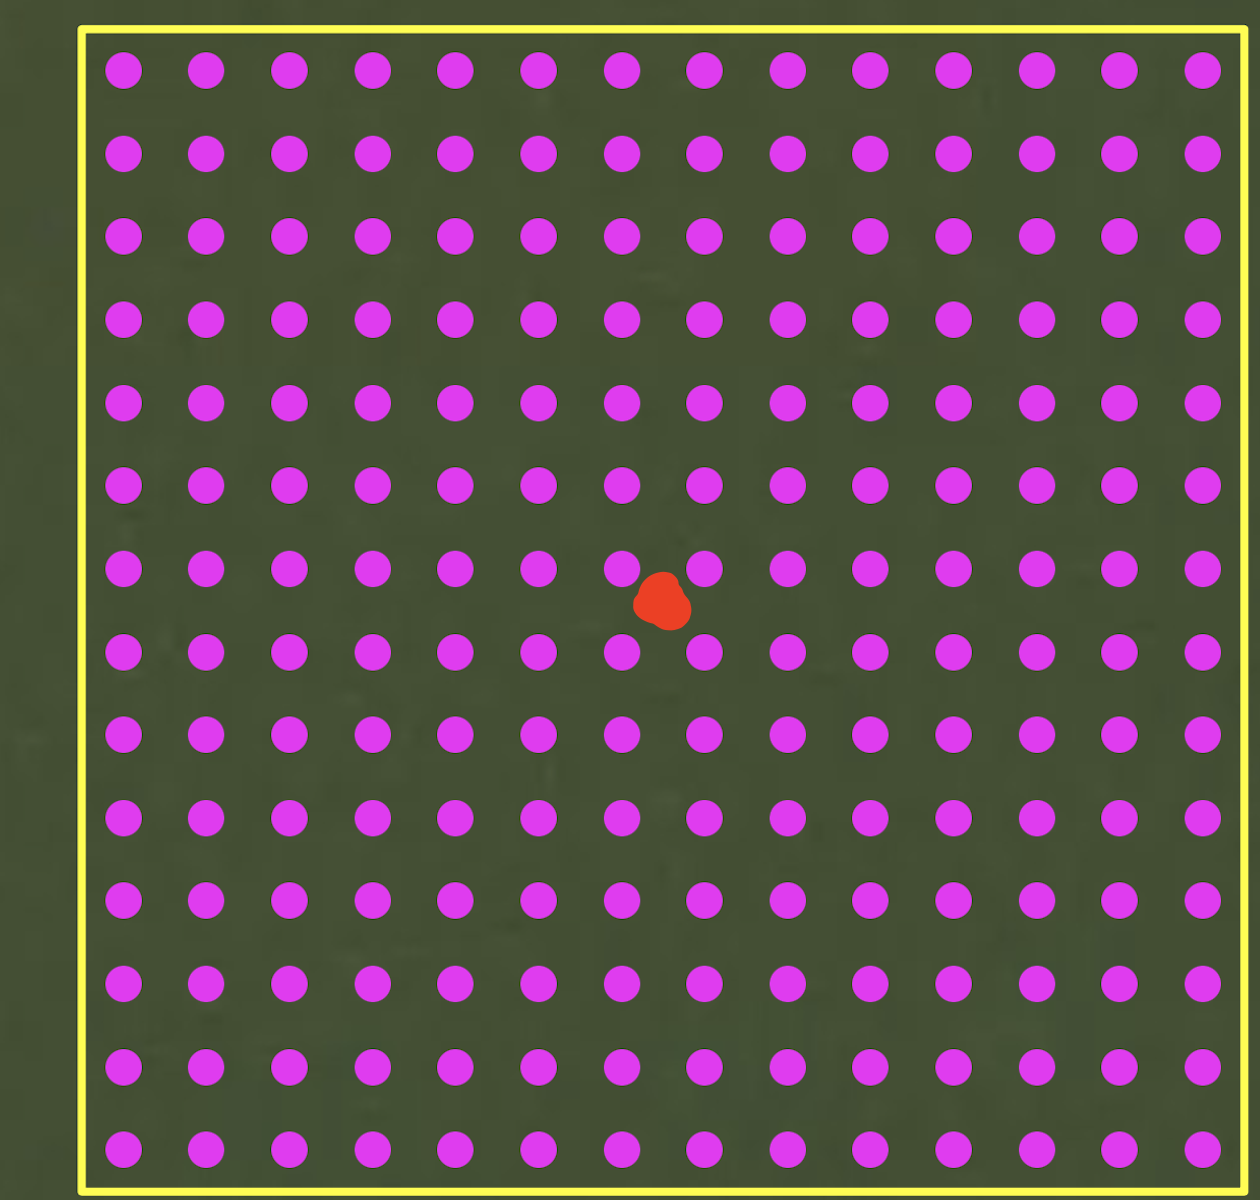